In [15]:
import pprint

from collections import Counter
from random import sample, shuffle

from ner.label_prep import _get_ner_tagging_data, get_ner_printable_text, get_label_mapping
from info.all_info import get_info_df, get_clean_inr_salary

In [16]:
tagging_data = _get_ner_tagging_data()

2021-07-24 00:36:08.089 | INFO     | ner.label_prep:_get_ner_tagging_data:97 - n records dropped due to some missing label: 419


In [27]:
for d in sample(tagging_data["tags"], 3):
    print(get_ner_printable_text(d))
    print("\n")
    print("-" * 10)
    print("\n")

education: b.tech tier 3 college
years of experience: [fresher:yoe]
prior experience: na
company: [tcs:company]
title/level: [system software engineer:title]
location: [banglore:location]
salary: [366000:salary]
total comp (salary + bonus + stock): 366000
benefits: standard
offcampus placement


----------


years of experience: [5:yoe]
prior experience: non-faang company
date of the offer: march 2021
company: [informatica:company]
title/level: [senior software engineer:title]
location: [bangalore, india:location]
salary: ~26,00,000 inr
relocation: 50,000 inr
signing bonus: na
stock bonus: na
bonus: performance-based target bonus of 10% of salary every year
total comp (salary + bonus ): 26 lakh + 2.6 lakh = 28.6 lakh for first year
benefits: standard
other details: did not negotiate. declined offer.


----------


education: b.tech in computer science
years of experience: [8:yoe]
prior experience: samsung
date of the offer: feb, 2019
company: [informatica:company]
title/level: [lead en

In [4]:
print(len(tagging_data["meta"]["company"]),
      len(tagging_data["meta"]["title"]),
      len(tagging_data["meta"]["salary"]),
      len(tagging_data["meta"]["yoe"]),
      len(tagging_data["meta"]["location"]))

3524 3525 3432 3192 3516


In [5]:
df = get_info_df()

2021-07-24 00:14:57.162 | INFO     | ner.label_prep:_get_ner_tagging_data:97 - n records dropped due to some missing label: 419


In [6]:
df.shape

(1933, 6)

In [7]:
df

,company,title,location,salary,yoe,original_text
0,tcs,systems engineer,bangalore,330000.0,0.0,education:btech from tier-3 college\nyears of ...
1,airtel,sde 1,delhi,1200000.0,0.0,education: b.tech (cse) from tier 1 college\ny...
2,l & t technology services,sde 1,bangalore,1300000.0,0.0,education: b.tech in computer engineering in t...
3,infosys,specialist programmer,n/a,800000.0,0.0,• education: b.tech in computer science\n• yea...
4,qualcomm,sde 2,bangalore,2100000.0,2.4,education : mtech cse from iit (2018 passout)\...
...,...,...,...,...,...,...
1928,n/a,sde 2,bangalore,3000000.0,3.0,education: b.tech. from a tier 3 university in...
1929,amazon,sde 1,bangalore,1600000.0,2.0,education: be cs (tier 3 college)\nyears of ex...
1930,reliance jio,n/a,bangalore,1560000.0,6.0,education: b.tech in computer science from tie...
1931,reliance jio,sde 2,delhi,2200000.0,4.0,education: b.tech from a tier 3 college\nyears...


In [8]:
df.to_csv("data/out/lc_info.csv", index=False)

In [8]:
df[df.location=="n/a"].shape

(164, 6)

In [9]:
df.location.value_counts()

bangalore      1057
hyderabad       306
delhi           253
n/a             164
mumbai           61
pune             43
chennai          35
mysore            9
kolkata           2
gandhinagar       2
coimbatore        1
Name: location, dtype: int64

In [17]:
import re
from random import sample

In [200]:
n = 0
total_salaries = []
for txt in df["original_text"]:
    total_ctc = re.search(r"\ntotal (comp|salary|ctc|pay|annual compensation)(?P<total_ctc_txt>.+)", txt)
    if total_ctc:
        n += 1
        ctc_txt = total_ctc.group("total_ctc_txt")
        symbol = None
        if "=>" in ctc_txt:
            symbol = "=>"
        elif "->" in ctc_txt:
            symbol = "->"
        elif "=" in ctc_txt:
            symbol = "="
        elif ":" in ctc_txt:
            symbol = ":"
        elif ")" in ctc_txt:
            symbol = ")"
        if not symbol:
            total_salaries.append(ctc_txt.strip())
        else:
            total_salaries.append(ctc_txt[ctc_txt.find(symbol)+1:].strip())
    else:
        total_salaries.append(-1)

In [201]:
n, len(total_salaries)

(1810, 1933)

In [224]:
TOTAL_SALARY_SPECIFICATION = [
    ("\d{6,7}", 1),
    ("\d{2,3}\,\d{2}\,\d{3}", 1),
    ("[1-9]\d{1,2}\.\d{1,2}", 100000),
    ("[1-9]\d{1,2}", 100000)
]

In [225]:
inr_total_salaries = []
for t in total_salaries:
    if t == -1:
        inr_total_salaries.append(-1)
        continue
    found = False
    for p, multiplier in TOTAL_SALARY_SPECIFICATION:
        match = re.findall(p, t)
        if match:
            total_ctc = float(match[0].replace(",", "")) * multiplier
            inr_total_salaries.append(total_ctc)
            found = True
            break
    if not found:
        inr_total_salaries.append(-1)

In [226]:
len(inr_total_salaries)

1933

In [227]:
df["total_salary"] = inr_total_salaries

In [228]:
df

,company,title,location,salary,yoe,original_text,total_salary
0,tcs,systems engineer,bangalore,330000.0,0.0,education:btech from tier-3 college\nyears of ...,330000.0
1,airtel,sde 1,delhi,1200000.0,0.0,education: b.tech (cse) from tier 1 college\ny...,1400000.0
2,l & t technology services,sde 1,bangalore,1300000.0,0.0,education: b.tech in computer engineering in t...,1300000.0
3,infosys,specialist programmer,n/a,800000.0,0.0,• education: b.tech in computer science\n• yea...,-1.0
4,qualcomm,sde 2,bangalore,2100000.0,2.4,education : mtech cse from iit (2018 passout)\...,3740000.0
...,...,...,...,...,...,...,...
1928,n/a,sde 2,bangalore,3000000.0,3.0,education: b.tech. from a tier 3 university in...,3000000.0
1929,amazon,sde 1,bangalore,1600000.0,2.0,education: be cs (tier 3 college)\nyears of ex...,2400000.0
1930,reliance jio,n/a,bangalore,1560000.0,6.0,education: b.tech in computer science from tie...,1960000.0
1931,reliance jio,sde 2,delhi,2200000.0,4.0,education: b.tech from a tier 3 college\nyears...,2730000.0


In [229]:
df.to_csv("data/out/lc_info.csv", index=False)

In [150]:
df.iloc[4, :].values

array(['qualcomm', 'sde 2', 'bangalore', 2100000.0, 2.4,
       'education : mtech cse from iit (2018 passout)\nyears of experience : 2.4 yrs\nprior experience : product based company us\ndate of offer : november 2020\ncompany : qualcomm rnd bengaluru\ntitle/level : senior engineer\nlocation: bangalore\nsalary: 21,00,000\njoinig bonus : 5,00,000\nstock bonus : 30000usd over 3 years(22.32 lacs approx)\nretention bonus : 2 lacs (after 1 year - one time)\nyearly bonus : around 10 % based on performance (2 lacs approx)\ntotal comp(salary + bonus + stock) : 37.4 (for first year)\nother details : they lowballed initially but increased once i show the other offer i had. rejected the offer as was interested in the work which was offered by other company. other company link :\nhttps://leetcode.com/discuss/compensation/915903/nutanix-or-mts-3-or-bangalore',
       3740000.0], dtype=object)

In [163]:
t = [(ts/s-1)*100 for s, ts in zip(df[df.total_salary!=-1]["salary"], df[df.total_salary!=-1]["total_salary"])]
t

[0.0,
 16.666666666666675,
 0.0,
 78.09523809523809,
 14.28571428571428,
 23.720930232558146,
 105.88235294117645,
 75.0,
 14.28571428571428,
 28.750000000000007,
 25.0,
 66.66666666666667,
 94.44444444444444,
 30.000000000000004,
 41.37931034482758,
 52.3076923076923,
 46.94576271186441,
 71.42857142857142,
 0.0,
 0.0,
 61.53846153846154,
 53.02325581395348,
 55.15624999999999,
 10.000000000000009,
 28.57142857142858,
 46.07142857142856,
 10.909090909090914,
 66.21621621621621,
 0.0,
 57.14285714285714,
 44.53125,
 0.0,
 0.0,
 -4.0000000000000036,
 77.50954838709679,
 6.25,
 44.44444444444444,
 30.000000000000004,
 69.38775510204083,
 0.0,
 19.23076923076923,
 -5.263157894736848,
 31.70731707317074,
 42.50000000000001,
 19.565217391304344,
 0.0,
 39.99999999999999,
 35.29411764705883,
 0.0,
 16.129032258064523,
 6.25,
 55.88235294117647,
 21.95121951219512,
 10.000000000000009,
 3.3333333333333437,
 0.0,
 0.0,
 43.47826086956521,
 32.6086956521739,
 0.0,
 16.36363636363636,
 17.346938

In [164]:
len(t)

1803

In [168]:
z = [_t for _t in t if _t >=0 and _t < 80]
len(z)

1591

In [166]:
import seaborn as sns

/Users/kuutsav/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

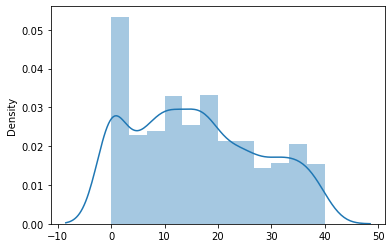

In [167]:
sns.distplot(z)

In [138]:
df[df.total_salary==-1].shape

(130, 7)

In [43]:
for txt in sample(total, 5):
    print(txt, "\n----\n")

education: b.tech.
years of experience: 4+
prior experience: startup (2017 launched) and other mid sized startup
company: ola cabs
title/level: sde 2
location: bangalore
salary: rs. 38,00,000/-
relocation/signing bonus: rs 2,00,000/-
stock bonus: n/a.
bonus: n/a.
total comp (salary + bonus + stock): rs. 40,00,000/-
benefits: ola standrad benifits.
other details: no negotiation 
----

education : btech in computer science (tier 2 college)
years of experience : 2
prior experience : 2yrs at samsung noida
date of offer : 6th august 2019
company: hike messenger
title : sde in android
location : delhi
base salary : rs 18lpa
joining bonus : rs. 100000
total ctc : rs 19lpa
other benefits : mobile and internet reimbursements 
----

i was being interviewed for se 2 where 1 round had ds plus design and other 2 rounds were purely design.
after that hm round was purely into specific technologies (which i feel that it should be on concept instead of expecting from candidate that they might have used